In [45]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# helper functions

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def unroll(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        l.append += series[key]
    return l

def add_shift(series):
    scale_factor = 0.2
    for key in series:
        if (key[-1] != 'z' and key[-1] != 'v'):
            rand_num = np.random.rand() * scale_factor - (scale_factor / 2)
            series[key] = [x + rand_num for x in series[key]]
    return series

def add_noise(series):
    scale_factor = 0.05
    for key in series:
        if (key[-1] != 'z' and key[-1] != 'v'):
            rand_num = np.random.rand() * scale_factor - (scale_factor / 2)
            series[key] = [x + (np.random.rand() * scale_factor - (scale_factor / 2)) for x in series[key]]
    return series

def rand_augment(series):
    series = add_shift(series)
    series = add_noise(series)
    return series

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 3.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 2.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 1.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 0.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

In [47]:
# defining contrastive loss function

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
            super(ContrastiveLoss, self).__init__()
            self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss

In [48]:
# defining siamese network

input_size = 224
fc_1 = 500
fc_2 = 400
fc_3 = 300
fc_4 = 200
fc_5 = 100
fc_6 = 50
output_size = 5

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, fc_1)
        self.fc2 = nn.Linear(fc_1, fc_2)
        self.fc3 = nn.Linear(fc_2, fc_3)
        self.fc4 = nn.Linear(fc_3, fc_4)
        self.fc5 = nn.Linear(fc_4, fc_5)
        self.fc6 = nn.Linear(fc_5, fc_6)
        self.fc7 = nn.Linear(fc_6, output_size)

    def forward(self, x1, x2):
        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        x1 = F.relu(self.fc3(x1))
        x1 = F.relu(self.fc4(x1))
        x1 = F.relu(self.fc5(x1))
        x1 = F.relu(self.fc6(x1))
        x1 = F.relu(self.fc7(x1))

        x2 = F.relu(self.fc1(x2))
        x2 = F.relu(self.fc2(x2))
        x2 = F.relu(self.fc3(x2))
        x2 = F.relu(self.fc4(x2))
        x2 = F.relu(self.fc5(x2))
        x2 = F.relu(self.fc6(x2))
        x2 = F.relu(self.fc7(x2))

        return x1, x2

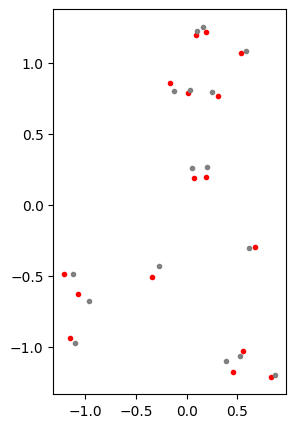

In [49]:
# testing augmentation strength

series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\WS-O1-F0-B5-S4-L0-L-0102.csv")

fig, ax = plt.subplots(1, figsize=(3, 5))

raw_x = []
raw_y = []

for key in series:
    if (key[-1] == 'x'):
        raw_x.append(series[key][2])
    elif (key[-1] == 'y'):
        raw_y.append(series[key][2])

series = rand_augment(series)

aug_x = []
aug_y = []

for key in series:
    if (key[-1] == 'x'):
        aug_x.append(series[key][2])
    elif (key[-1] == 'y'):
        aug_y.append(series[key][2])

ax.plot(raw_x, raw_y, '.', c='r')
ax.plot(aug_x, aug_y, '.', color='gray')